In [0]:
"""
From Ahmad:
I would suggest to try multiple models for classification
and regression and compare them to make your project more
significant. Also focus a bit more on the EDA part and try
to make an interesting analysis with nice visualisations.
There could be interesting questions which could be answered
by your analysis, eg: which category of the projects have a
higher success rate. Also if this data-set was already used
in a kaggle competition, you can also report and compare your
accuracy with the accuracy of the wining team of the
competition in kaggle.
"""

In [0]:
# imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the data

In [164]:
df = pd.read_csv("https://raw.githubusercontent.com/tbacha/DMML2019_Team_Apple/master/data/ks-projects-201801.csv")
df.head(5)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


# Data cleaning
Data to clean:
* deadline, launched --> datetime

No categorical data in the form of integers --> using strings is fine

The Kaggle user already converted amounts to USD --> we will use these columns


Remove undefined/live/suspended (about 2.1% of the data) --> focus on historical data

In [165]:
df["deadline"] = pd.to_datetime(df["deadline"])
df["launched"] = pd.to_datetime(df["launched"])
df.dtypes

ID                           int64
name                        object
category                    object
main_category               object
currency                    object
deadline            datetime64[ns]
goal                       float64
launched            datetime64[ns]
pledged                    float64
state                       object
backers                      int64
country                     object
usd pledged                float64
usd_pledged_real           float64
usd_goal_real              float64
dtype: object

Removing the undefined/live and suspended status.

In [166]:
#selection de 'state' avec une valeur individuel
    #df.loc[(df['state'] == 'suspended')]
    #df.loc[(df['state'] == 'undefined')]
    #df.loc[(df['state'] == 'live')]
#selection: avec la colonne "state" pour les valeurs undefined/live and suspended
      print("le nombre de ligne attendu après le tri est de = ", (378661-8207))
      df.loc[(df['state'] == 'live') | (df['state'] == 'undefined') | (df['state'] == 'suspended') ].shape, df.shape
      

le nombre de ligne attendu après le tri est de =  370454


((8207, 15), (378661, 15))

Le dataFrame après tri est nommé "df1". (possible de le renommer)

In [167]:
df1 = df
df1 = df1[df1['state'] != 'live']
df1 = df1[df1['state'] != 'undefined']
df1 = df1[df1['state'] != 'suspended']
df1.shape

(370454, 15)

# EDA

Text(0, 0.5, 'Main Category')

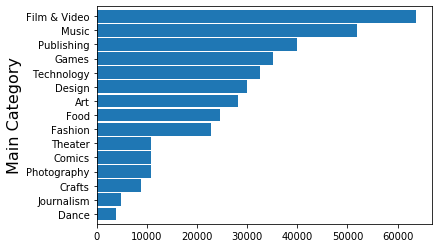

In [168]:
df_main_cat = df.groupby(["main_category"])["ID"].nunique().sort_values(ascending=True)
ax = df_main_cat.plot(kind="barh", x="main_category", width=0.9)
ax.set_ylabel("Main Category", size=16)

Text(0.5, 1.0, 'Distribution of states')

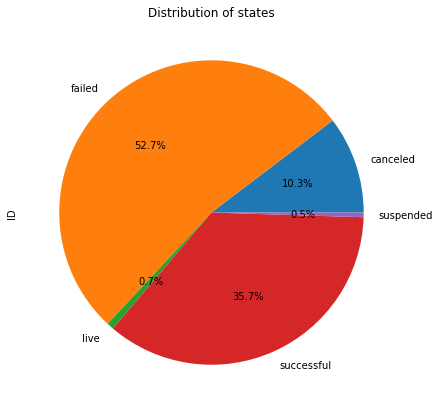

In [169]:
df_state = df[(df["state"] != "undefined")].groupby(["state"])["ID"].nunique()
ax = df_state.plot(kind="pie", figsize=(7,7), autopct="%1.1f%%")
ax.set_title("Distribution of states")

Text(0.5, 1.0, '5 most represented countries')

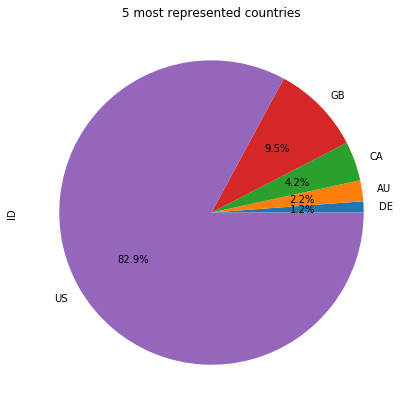

In [170]:
df_country = df.groupby(["country"])["ID"].count().sort_values()
ax = df_country.tail(5).plot(kind="pie", figsize=(7,7), autopct="%1.1f%%")
ax.set_title("5 most represented countries")

# EDA BAKERS
Analyse des bakers selon plusieurs paramètre:</br>


1.   Quantité de bakers selon les statuts finaux (mean, max, min, median, mode)
2.   Quantité de bakers selon le type de projet (mean, max, min, median, mode)
3.   Quantité de bakers selon le pays (mean, max, min, median, mode)
4.   etc....




## Bakers selon le statut final


In [171]:
df1_statut_complet = df1.groupby(['state'])['backers'].agg(['mean','min','max','median',lambda x: x.mode()[0]])
df1_statut_complet

,mean,min,max,median,<lambda_0>
state,,,,,
canceled,25.987390,0,9326,3,0
failed,16.422352,0,6550,3,0
successful,263.921362,0,219382,71,19


## Bakers selon la main_category


In [176]:
df1_type_complet = df1.groupby(['main_category'])['backers'].agg(['mean','min','max','median',lambda x: x.mode()[0]])
df1_type_complet

,mean,min,max,median,<lambda_0>
main_category,,,,,
Art,42.378925,0,22834,10,0
Comics,135.629198,0,14952,40,0
Crafts,27.629258,0,12705,3,0
Dance,43.097430,0,4133,27,0
Design,241.593576,0,154926,29,0
Fashion,61.901226,0,15129,5,0
Film & Video,67.286889,0,91585,12,0
Food,54.403833,0,13116,6,0
Games,325.569622,0,219382,30,0


##Bakers selon la somme reçu
selon le statut

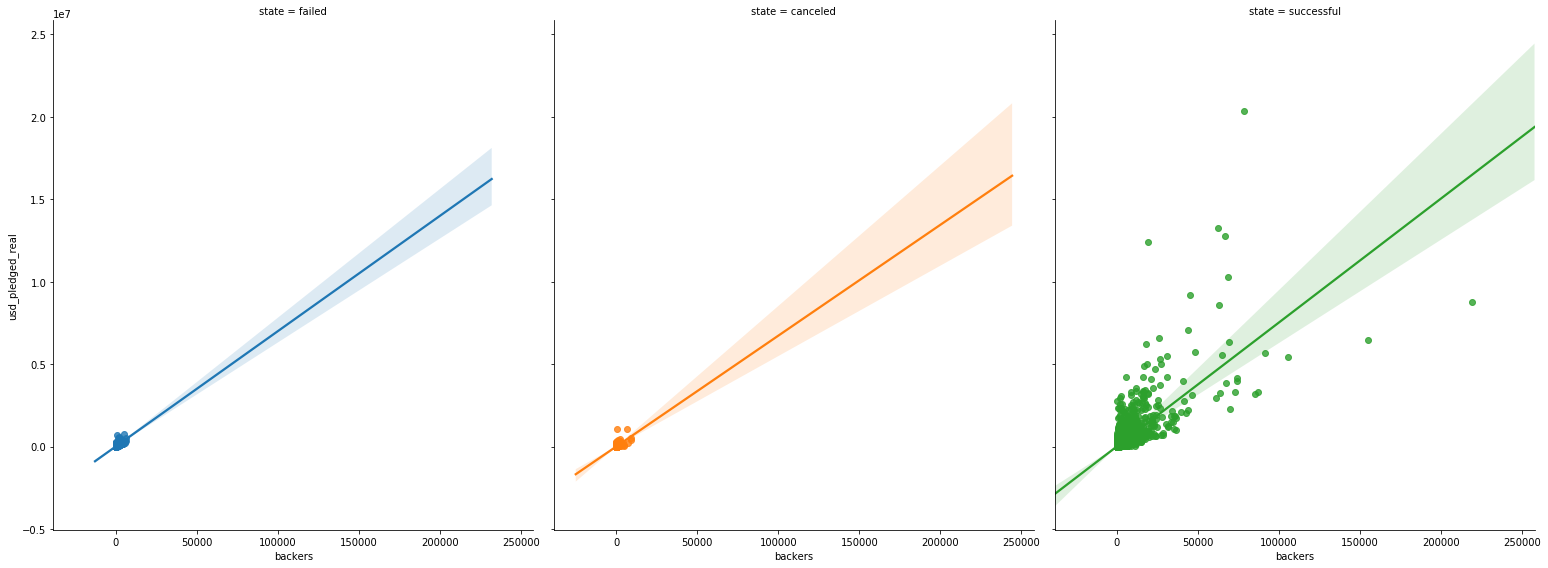

In [143]:
import seaborn as sns

sns.lmplot("backers", "usd_pledged_real",  data=df1, hue='state', col='state', height=8, aspect=.9, x_jitter=2)

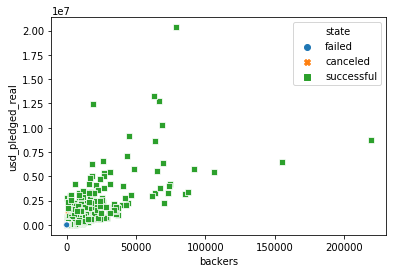

In [178]:
ax = sns.scatterplot(x="backers", y="usd_pledged_real", hue="state", style="state", data=df1)

##Bakers selon la somme souhaitée
selon le statut

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


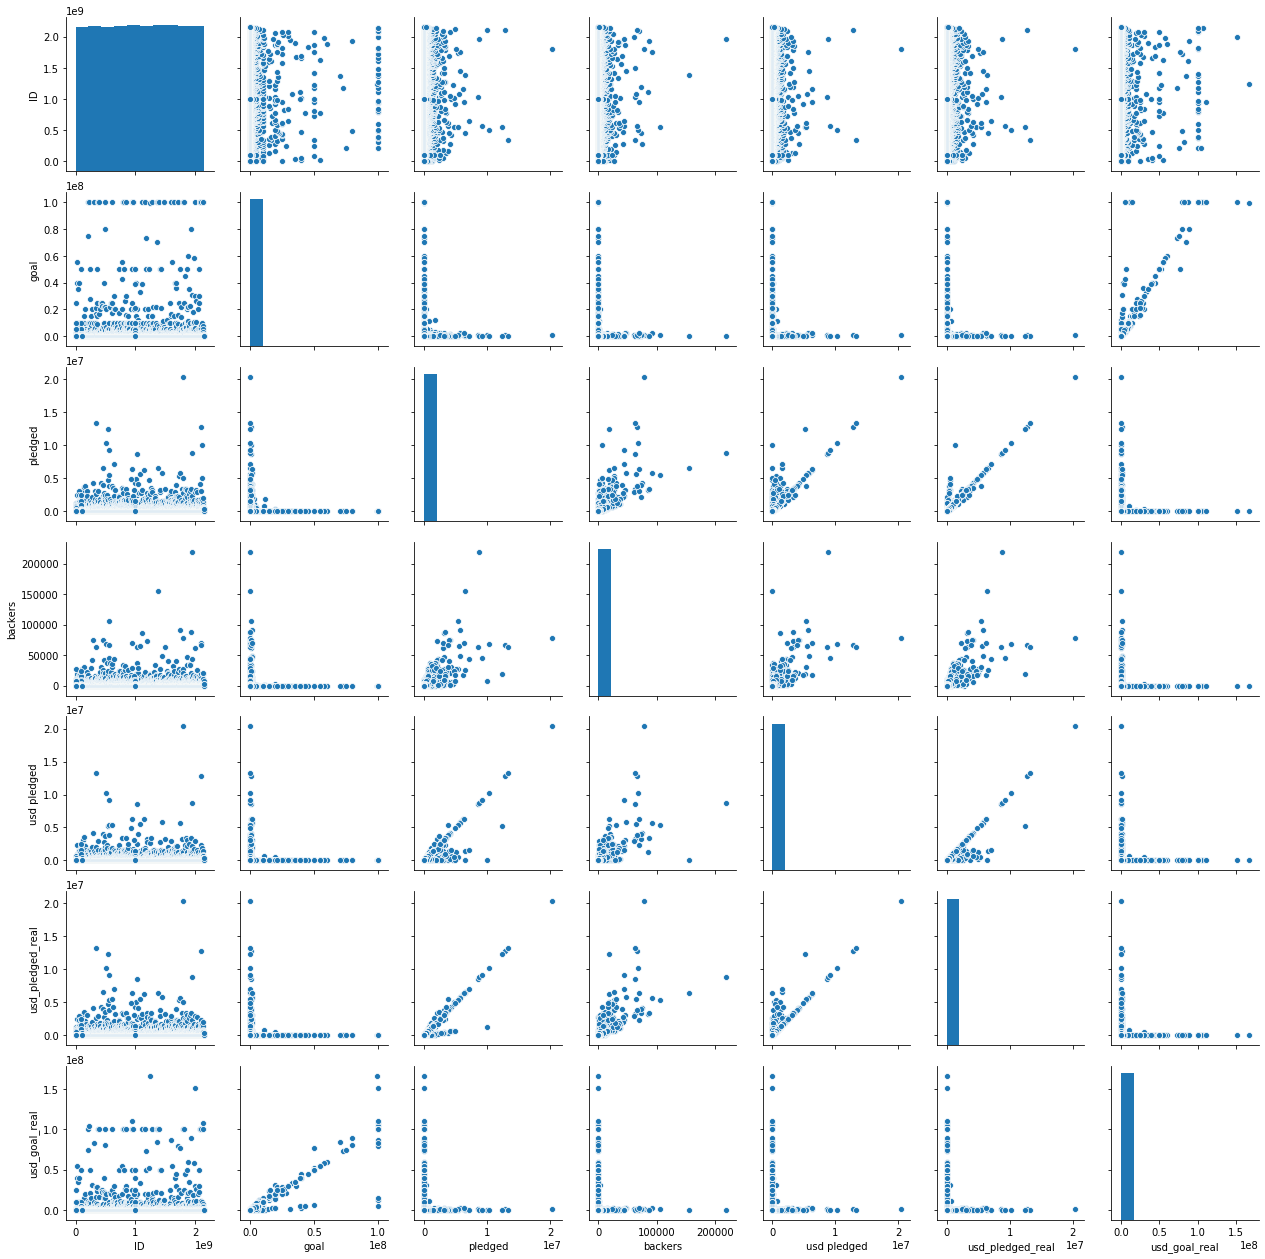

In [177]:
sns.pairplot(df1);